In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *

In [2]:
def linfit(x, m, b):
    return m * x + b
def linfit_b(x, m):
    return m * x
def linfit_m(x, b):
    return x+b

In [3]:
########################################################
def getReddening_err(table, band1='r', band2='w2'):
    
    pc0  = table['P0_w2']
    P1W2p = table['P0_w2p']
    R_source = table['R_source']
    indx, = np.where(R_source==0)
    pc0[indx] = P1W2p[indx]
    
    Epc0 = table['P0_w2_e']
    inc  = table['inc']   
    Einc = table['inc_e']
    
    if band1=='w2':
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1='w1', band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
        gamma = gamma/3.107
        d_gamma = gamma/3.107
    else:
        a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
        gamma = (a*pc0**3+b*pc0**2+c*pc0+d)
        d_gamma = np.abs((3*a*pc0**2+2*b*pc0+c)*Epc0)
    
    indx, = np.where(gamma<0)
    gamma[indx]=0
    d_gamma[indx]=0

    q2 = 10**(-1.*theta)
    F = log_a_b(inc, q2)
    dF2 = Elogab2(inc, q2, Einc)
    dM2 = dF2*(a*pc0**3+b*pc0**2+c*pc0+d)**2+(F*(3*a*pc0**2+2*b*pc0+c)*Epc0)**2
    
    Aj_e2 = np.sqrt(dM2)
    Aj = F*gamma
    
    return Aj_e2
########################################################

In [4]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc = table['pgc']

print len(pgc)

10736


In [5]:
def makeCuster(table, band='i', reject=[], weird=[], clusterName='Coma Cluster', 
               nest='NEST_100001', isVirgo=False, slope=None):
    
    ctl   = np.genfromtxt(nest+'.csv' , delimiter='|', filling_values=-1, 
                          names=True, dtype=None, encoding=None)
    PGC = ctl['PGC']
    
    pgc       = table['pgc']
    logWimx   = table['logWimx']
    logWimx_e = table['logWimx_e']
    Vhel      = table['Vhel']

    Aj_e2     = getReddening_err(table, band1=band, band2='w2')


    mag = table[band+'_sss']
    mag_e = np.sqrt((mag*0.+0.05)**2+Aj_e2**2)    
    
    pgc_ = []
    logWimx_ = []
    logWimx_e_ = []
    mag_ = []
    mag_e_ = []
    Sqlt_ = []
    Wqlt_ = []
    
    for i, idd in enumerate(pgc):
        if idd in PGC and not idd in reject:
            if isVirgo:
                if Vhel[i]<600 or (Vhel[i]>1200 and Vhel[i]<1600):
                    if mag[i]>5 and mag[i]<20:
                        pgc_.append(idd)
                        logWimx_.append(logWimx[i])
                        logWimx_e_.append(logWimx_e[i])
                        mag_.append(mag[i])
                        mag_e_.append(mag_e[i])
                        Sqlt_.append(table['Sqlt'][i])
                        Wqlt_.append(table['Wqlt'][i])
            else:
                 if mag[i]>5 and mag[i]<20:
                    pgc_.append(idd)
                    logWimx_.append(logWimx[i])
                    logWimx_e_.append(logWimx_e[i])
                    mag_.append(mag[i])
                    mag_e_.append(mag_e[i])
                    Sqlt_.append(table['Sqlt'][i])
                    Wqlt_.append(table['Wqlt'][i])                
            
            
    pgc_=np.asarray(pgc_)
    logWimx_=np.asarray(logWimx_)
    logWimx_e_=np.asarray(logWimx_e_)
    mag_=np.asarray(mag_)
    mag_e_=np.asarray(mag_e_)
    Sqlt_=np.asarray(Sqlt_)
    Wqlt_=np.asarray(Wqlt_)
    N = len(pgc_)
    dofit = np.zeros(N)
      
    for i in range(N):
        if not pgc_[i] in weird:
            if not band in ['w1','w2'] and Sqlt_[i]>=2:
                dofit[i]=1
            elif band in ['w1','w2'] and Wqlt_[i]>=2:
                dofit[i]=1
            else:
                dofit[i]=2
        else:
            dofit[i]=2
    indx, = np.where(dofit==2)
    pgc_w = pgc_[indx]
    logWimx_w= logWimx_[indx]
    logWimx_e_w= logWimx_e_[indx]
    mag_w= mag_[indx]
    mag_e_w= mag_e_[indx]
    
    indx, = np.where(dofit==1)
    pgc_ = pgc_[indx]
    logWimx_= logWimx_[indx]
    logWimx_e_= logWimx_e_[indx]
    mag_= mag_[indx]
    mag_e_= mag_e_[indx]
    
    try:
        ### 'Virgo W cluster' condition
        if band in ['u', 'g']:
            indx = np.asarray([int(i) for i, idd in enumerate(pgc_) if not idd in [39886, 39114]])
            logWimx_0= logWimx_[indx]
            logWimx_e_0= logWimx_e_[indx]
            mag_0= mag_[indx]
            mag_e_0= mag_e_[indx]     

            if slope is None:
                fit, cov = curve_fit(linfit, mag_0, logWimx_0-2.5, sigma=np.sqrt(logWimx_e_0**2+0.01**2))
            else:
                fit, cov = curve_fit(linfit_m, mag_0/slope, logWimx_0-2.5, sigma=np.sqrt(logWimx_e_0**2+0.01**2))
            
        else:
            if slope is None :
                fit, cov = curve_fit(linfit, mag_, logWimx_-2.5, sigma=np.sqrt(logWimx_e_**2+0.01**2))
            else:
                fit, cov = curve_fit(linfit_m, mag_/slope, logWimx_-2.5, sigma=np.sqrt(logWimx_e_**2+0.01**2))
            
        if slope is None :
            m, b = fit
            me = np.sqrt(cov[0,0])
            be = np.sqrt(cov[1,1])
            mbe = cov[1,0]    
            m0 = 1./m
            b0 = -b/m
            dm0 = np.abs(me/m**2)
            db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
        else:
            b = fit[0]
            me = 0
            be = np.sqrt(cov[0])
            m0 = slope
            b0 = -b*slope
            dm0 = 0
            db0 = np.abs(slope*be)          
    except:
        m0,b0,dm0,db0 = 0,0,0,0
        'Warning ....'
    
    outDict = {'pgc':pgc_, 'slope':m0, 'zp':b0, 'slope_e':dm0, 'zp_e':db0, 
               'nest':nest, 'name':clusterName, 'band':band, 
               'mag':mag_, 'mag_e':mag_e_, 'logWimx':logWimx_, 'logWimx_e':logWimx_e_,
              'pgc_w':pgc_w, 'mag_w':mag_w, 'mag_e_w':mag_e_w, 'logWimx_w':logWimx_w, 
               'logWimx_e_w':logWimx_e_w, 'reject':reject, 'weird':weird}
    
    return outDict


In [6]:
def allCluster(band='i', slope=None):
    
    Clusters = {}

    reject = [43164,44405,93666]
    weird = [43511]
    myDict = makeCuster(table, nest='NEST_100001', clusterName='Coma', 
                        reject=reject, weird=weird, band=band, slope=slope)
    Clusters['NEST_100001'] = myDict

    reject = []
    weird = [41440]
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Virgo', nest='NEST_100002', isVirgo=True, band=band, slope=slope)
    Clusters['NEST_100002'] = myDict


    ### SOUTH
    reject = []
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Centaurus', nest='NEST_100003', band=band, slope=slope)
    Clusters['NEST_100003'] = myDict

    reject = [36323,36328,36330,36608,200155]
    weird = [37140]
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Abell 1367', nest='NEST_100005', band=band, slope=slope)
    Clusters['NEST_100005'] = myDict


    ### SOUTH
    reject = []
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Hydra', nest='NEST_100006', band=band, slope=slope)
    Clusters['NEST_100006'] = myDict

    reject = [56977,2790835]
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Abell 2151 (Hercules)', nest='NEST_100007', band=band, slope=slope)
    Clusters['NEST_100007'] = myDict


    reject = [37550]
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Ursa Major', nest='NEST_100008', band=band, slope=slope)
    Clusters['NEST_100008'] = myDict

    ### SOUTH
    reject = []
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Antila', nest='NEST_100014', band=band, slope=slope)
    Clusters['NEST_100014'] = myDict

    reject = [38333]
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='NGC4065', nest='NEST_100018', band=band, slope=slope)
    Clusters['NEST_100018'] = myDict

    reject = [23308]
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Cancer', nest='NEST_100030', band=band, slope=slope)
    Clusters['NEST_100030'] = myDict

    reject = [] 
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Virgo W', nest='NEST_120002', band=band, slope=slope)
    Clusters['NEST_120002'] = myDict

    reject = [] 
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Abell 262', nest='NEST_200003', band=band, slope=slope)
    Clusters['NEST_200003'] = myDict

    reject = [3446,4020] 
    weird = [1904373]
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='NGC410 Cluster', nest='NEST_200005', band=band, slope=slope)
    Clusters['NEST_200005'] = myDict

    reject = [4740,4876,5008] 
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='NGC507 Cluster', nest='NEST_200006', band=band, slope=slope)
    Clusters['NEST_200006'] = myDict

    ### SOUTH
    reject = [] 
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Fornax', nest='NEST_200015', band=band, slope=slope)
    Clusters['NEST_200015'] = myDict

    reject = [11150,11199,138562,3647754] 
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Abell 400', nest='NEST_200012', band=band, slope=slope)
    Clusters['NEST_200012'] = myDict

    reject = [85526,85643,90431,197699] 
    weird = [5057398]
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Abell 2634/66', nest='NEST_200016', band=band, slope=slope)
    Clusters['NEST_200016'] = myDict

    ### SOUTH
    reject = [] 
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Abell 539', nest='NEST_200017', band=band, slope=slope)
    Clusters['NEST_200017'] = myDict

    reject = [1724] 
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='NGC70 Cluster', nest='NEST_200037', band=band, slope=slope)
    Clusters['NEST_200037'] = myDict

    reject = [90474] 
    weird = [1707532]
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='NGC80 Cluster', nest='NEST_200045', band=band, slope=slope)
    Clusters['NEST_200045'] = myDict

    reject = [70712, 70998, 71360] 
    weird = []
    myDict = makeCuster(table, reject=reject, weird=weird, 
               clusterName='Pegasus', nest='NEST_200092', band=band, slope=slope)
    Clusters['NEST_200092'] = myDict
    
    return Clusters

In [15]:
def makeFig(band='i', xLim = (1.5,2.9), yLim = (19.5,6.5)):
    
    fig = py.figure(figsize=(5,5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
    ax = fig.add_subplot(111)
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)

    if not band in ['w1','w2']:
        ax.set_ylabel(r'$'+band+'^* \/\/ [AB]$', fontsize=18) 
    else:
        ax.set_ylabel(r'$'+band.upper()+'^* \/\/ [AB]$', fontsize=18)
    ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    return ax

In [16]:
def plotCluster(ax, Clusters, nest, color=None, plotWeird=False, offset=0, 
                plotFit=False, alpha=0.7, symbol='o', plotErrors=False, markersize=4):
    
    myCluster = Clusters[nest]

    band = myCluster['band']   
    logWimx_  = myCluster['logWimx']
    logWimx_e_= myCluster['logWimx_e']
    mag_      = myCluster['mag']
    mag_e_    = myCluster['mag_e']

    logWimx_w  = myCluster['logWimx_w']
    logWimx_e_w= myCluster['logWimx_e_w']
    mag_w      = myCluster['mag_w']
    mag_e_w   = myCluster['mag_e_w']

    slope = myCluster['slope']
    zp = myCluster['zp']
    
    if slope==0: return

    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    if color==None: color = dye[band]
    if offset==None:
        offset = zp

    if plotWeird:
        if plotErrors:
            ax.errorbar(logWimx_w, mag_w-offset, xerr=logWimx_e_w, yerr=mag_e_w, fmt=symbol, 
                            color='k', markersize=3, markerfacecolor='white') 
        else:
            ax.errorbar(logWimx_w, mag_w-offset, xerr=logWimx_e_w*0, yerr=mag_e_w*0, fmt=symbol, 
                            color='k', markersize=3, markerfacecolor='white')             
    
    if plotErrors:
        ax.errorbar(logWimx_, mag_-offset, xerr=logWimx_e_, yerr=mag_e_, fmt=symbol, 
                        color=color, markersize=4, alpha=alpha)
    else:
        ax.errorbar(logWimx_, mag_-offset, xerr=logWimx_e_*0, yerr=mag_e_*0, fmt=symbol, 
                        color=color, markersize=4, alpha=alpha)        
    

    if plotFit:
        x = np.linspace(0,3,50)
        y = slope*(x-2.5)+zp-offset
        ax.plot(x,y, 'k--')  

In [17]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [18]:
Clusters = allCluster(band='i', slope=None)
Clusters_ = allCluster(band='w1', slope=None)

key0 = 'NEST_100001'
myCluster = Clusters[key0]
myCluster_ = Clusters_[key0]
print key0, len(myCluster['mag']), len(myCluster_['mag'])
u = len(myCluster['mag'])
v =  len(myCluster_['mag'])
for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        myCluster_ = Clusters_[key]
        print key, len(myCluster['mag']),len(myCluster_['mag'])
        u+=len(myCluster['mag'])
        v+=len(myCluster_['mag'])
             
print u,v    

NEST_100001 79 75
NEST_200092 27 25
NEST_200037 11 11
NEST_200017 0 22
NEST_200005 35 31
NEST_200006 20 22
NEST_100014 0 17
NEST_200003 7 55
NEST_120002 16 16
NEST_100003 0 23
NEST_100002 38 36
NEST_100005 68 62
NEST_200045 13 12
NEST_100007 39 33
NEST_100006 0 46
NEST_100008 38 37
NEST_200016 29 26
NEST_100030 18 17
NEST_200015 0 19
NEST_100018 14 12
NEST_200012 21 23
473 620


In [19]:
Clusters = allCluster(band='r', slope=-8.71)
for key in Clusters:
    print key, Clusters[key]['name'], "%.2f"%Clusters[key]['slope'], "%.2f"%Clusters[key]['zp']

NEST_200092 Pegasus -8.71 12.56
NEST_200037 NGC70 Cluster -8.71 14.02
NEST_200017 Abell 539 0.00 0.00
NEST_200005 NGC410 Cluster -8.71 13.36
NEST_200006 NGC507 Cluster -8.71 13.33
NEST_100014 Antila 0.00 0.00
NEST_200003 Abell 262 -8.71 12.91
NEST_100001 Coma -8.71 14.14
NEST_120002 Virgo W -8.71 11.92
NEST_100003 Centaurus 0.00 0.00
NEST_100002 Virgo -8.71 10.15
NEST_100005 Abell 1367 -8.71 14.09
NEST_200045 NGC80 Cluster -8.71 13.94
NEST_100007 Abell 2151 (Hercules) -8.71 15.32
NEST_100006 Hydra 0.00 0.00
NEST_100008 Ursa Major -8.71 10.66
NEST_200016 Abell 2634/66 -8.71 14.72
NEST_100030 Cancer -8.71 13.54
NEST_200015 Fornax 0.00 0.00
NEST_100018 NGC4065 -8.71 14.44
NEST_200012 Abell 400 -8.71 14.21


In [20]:
def TF_iter(key0 = 'NEST_100002', band = 'i', n_iter=10, verbose=False):
    
    Clusters = allCluster(band=band, slope=None)
    
    for repeat in range(n_iter):
        myCluster = Clusters[key0]
        zp = myCluster['zp']
        mag = myCluster['mag']-zp
        mag_e = myCluster['mag_e']
        logWimx = myCluster['logWimx']
        logWimx_e = myCluster['logWimx_e']

        for i, key in enumerate(Clusters):
            if key!=key0:
                myCluster = Clusters[key]
                zp = myCluster['zp']
                mag = np.concatenate((mag, myCluster['mag']-zp))
                mag_e = np.concatenate((mag_e, myCluster['mag_e']))
                logWimx = np.concatenate((logWimx, myCluster['logWimx']))
                logWimx_e = np.concatenate((logWimx_e, myCluster['logWimx_e']))


        fit, cov = curve_fit(linfit, mag, logWimx-2.5, sigma=np.sqrt(logWimx_e**2+0.01**2))
        m, b = fit
        slope = 1./m
        zp = -b/m

        Clusters = allCluster(band=band, slope=slope)

        if verbose:
            print slope, zp

    if verbose: 
        for key in Clusters:
            print key, Clusters[key]['name'], "%.2f"%Clusters[key]['slope'], "%.2f"%Clusters[key]['zp']
    
    return Clusters, slope, zp

In [37]:
band = 'z'
Clusters, slope0, zp0 = TF_iter(band = band, n_iter=5, verbose=False)
print slope0, zp0

-8.444965991262732 9.024283546144569e-06


472 472 472
-8.444965991262732 9.024283546144569e-06
-8.44490913577168 9.927807711723348


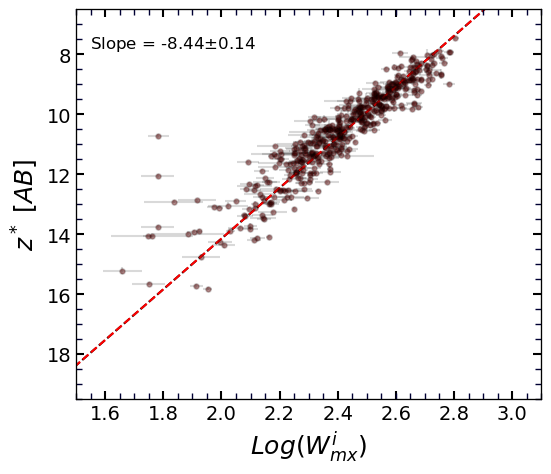

In [46]:
####  plotCluster(ax, Clusters, nest, color=None, plotWeird=False, offset=0, 
#                 plotFit=False, alpha=0.7, symbol='o', plotErrors=False)

dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
cmap = get_cmap(21)
# ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (10,-5) ) 
ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (19.5,6.5) )

key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
mag = myCluster['mag']-zp_virgo
mag_e = myCluster['mag_e']
logWimx = myCluster['logWimx']
logWimx_e = myCluster['logWimx_e']
pgc_ = myCluster['pgc']

for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        plotCluster(ax, Clusters, key, color='k', offset=zp_-zp_virgo, plotErrors=True, alpha=0.15, markersize=0) # cmap(i)
        mag = np.concatenate((mag, myCluster['mag']-zp_))
        mag_e = np.concatenate((mag_e, myCluster['mag_e']))
        logWimx = np.concatenate((logWimx, myCluster['logWimx']))
        logWimx_e = np.concatenate((logWimx_e, myCluster['logWimx_e']))
        pgc_ =  np.concatenate((pgc_, myCluster['pgc']))
    else:
        plotCluster(ax, Clusters, key, color='k', offset=0, plotErrors=True, alpha=0.15, markersize=0)
        

x = np.linspace(0,3.5,50)
y = slope0*(x-2.5)
ax.plot(x,y+zp_virgo, 'k--') 
ax.plot(logWimx, mag+zp_virgo, '.', color=dye[band], alpha=0.3)   
print len(mag), len(logWimx), len(logWimx_e)
print slope0, zp0


## Traditional one way linear fit    
mag_ = mag+zp_virgo
logWimx_ = logWimx
logWimx_e_ = logWimx_e
fit, cov = curve_fit(linfit, mag_, logWimx_-2.5, sigma=np.sqrt(logWimx_e_**2+0.01**2))
m, b = fit
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]

y = np.linspace(5,20,50)
x = m*y+b+2.5
ax.plot(x,y, 'r--')  
m0 = 1./m
b0 = -b/m
dm0 = np.abs(me/m**2)
db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.97*Xlm[0]+0.03*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='k')


print m0, b0

In [47]:
from bokeh.plotting import *
from bokeh.embed import components
from bokeh.models import ColumnDataSource, LabelSet, HoverTool, Range1d, Label, TapTool, OpenURL, CustomJS, CrosshairTool

output_notebook()

Loading BokehJS ...

In [62]:
if True:
    
    hover = HoverTool(tooltips=[ 
        ("LogWimx", "@LogWimx"),
        (band, "@"+band),
        ("PGC", "@PGC"),
        ])

    hover.point_policy='snap_to_data'
    hover.line_policy='nearest'#'prev'

    TOOLS = ['pan', 'tap', 'wheel_zoom', 'box_zoom', 'reset', 'save']

    p = figure(tools=TOOLS, toolbar_location="below", plot_width=550, plot_height=450)
    p.title.text_font_size = '14pt'
    p.title.text_color = 'green'
    p.grid.grid_line_color="gainsboro"
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    rang=dye[band] 

    source = ColumnDataSource({'LogWimx': logWimx_, band: mag_, 'PGC': pgc_})
    render = p.circle('LogWimx', band, source=source, size=5, color=rang, alpha=0.7, hover_color='red', hover_alpha=1, hover_line_color='red',
                        
                        # set visual properties for selected glyphs
                        selection_fill_color=rang,

                        # set visual properties for non-selected glyphs
                        nonselection_fill_alpha=1,
                        nonselection_fill_color=rang,)
                      
    p.line(x, y, line_width=1, color="black", line_dash='dashed')
    p.legend.location = "top_right"
    
    p.x_range = Range1d(1.5,3.1)
    p.y_range = Range1d(19.5,6.5)

    p.xaxis.axis_label = 'Log(W^i_mx)'
    p.yaxis.axis_label = band+'* [mag]'
    p.xaxis.axis_label_text_font_size = "14pt"
    p.yaxis.axis_label_text_font_size = "14pt"
    p.grid.grid_line_color="gainsboro"
    p.yaxis.major_label_text_font_size = "12pt"
    p.xaxis.major_label_text_font_size = "12pt"
    
    
    code = """
        
        var index_selected = source.selected['1d']['indices'][0];
        var win = window.open("http://edd.ifa.hawaii.edu/cf4_photometry/get_sdss_cf4.php?pgc="+source.data['PGC'][index_selected]+"#t01", "EDDesn", "width=1200, height=1000");
        try {win.focus();} catch (e){}

    """

    taptool = p.select(type=TapTool)
    taptool.callback = CustomJS(args=dict(source=source), code=code)



    ttp = """
        <div>
            <div>
                <span style="font-size: 16px; color: blue;">PGC:</span>
                <span style="font-size: 16px; font-weight: bold;">@PGC{int}</span>
            </div>
            <div>
                <span style="font-size: 16px; color: blue;">LogWimx:</span>
                <span style="font-size: 16px; font-weight: bold;">@LogWimx</span>
            </div>  
            <div>
                <span style="font-size: 16px; color: blue;">"""+band+""":</span>
                <span style="font-size: 16px; font-weight: bold;">@"""+band+"""{0.2f}</span>
            </div>          
        </div>
    """


    hover = HoverTool(tooltips=ttp, renderers=[render])

    hover.point_policy='snap_to_data'
    hover.line_policy='nearest'
    #hover.mode='vline'
    p.add_tools(hover)   

    cross = CrosshairTool()
    #cross.dimensions='height'
    cross.line_alpha = 0.3
    cross.line_color = 'green'
    p.add_tools(cross)     

    mytext = Label(x=20, y=290, text="Slope= "+"%.2f" % m0+'+-'+"%.2f" % dm0, text_color='black', text_font_size='12pt', x_units='screen', y_units='screen')
    p.add_layout(mytext)
    mytext = Label(x=20, y=260, text="ZP= "+"%.2f" % b0+'+-'+"%.2f" % db0, text_color='black', text_font_size='12pt', x_units='screen', y_units='screen')
    p.add_layout(mytext)    
    
    show(p)